# TP6 : image stitching with interest points

In this tutorial, a few images are provided, but you are strongly encouraged to retrieve and experiment with other images from the web.

The image processing practical exercises are carried out in Python3, using the [scikit-image](http://scikit-image.org/docs/stable/) library. The arrays (`ndarray`) used by this library to manipulate images come from the [numpy](https://docs.scipy.org/doc/) library. Images and other figures are displayed using [matplotlib](https://matplotlib.org/contents.html). The documentation for these three libraries will come in very handy.

In this lab, questions will be indicated in a **question** block, and answers will be given in the **answer** block below the question block. Your answers should be written in [markdown](https://github.com/adam-p/markdown-here/wiki/Markdown-Cheatsheet). This will allow you to answer not only with text, but also with tables and images.

:::{important}
The questions asked in this TP generally **require short but justified answers**. A simple yes or no is of no use to us in judging your understanding of the question and its answer...
:::

:::{attention}
Sometimes there are several sub-questions in the same question. **Please remember to answer all sub-questions**.
:::

PS: This lab is a very modified version of a scikit-image demo available here https://github.com/scikit-image/scikit-image-demos

In [1]:
%pip install -q ipywidgets==8.1.1 matplotlib scikit-image ipympl numpy
# the first line is used to install the python packages we'll need for our practical work
# the second line allows you to display the figures directly in your notebook and interact with them.


[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import io
from skimage import transform as tf
from skimage import exposure
import math
from skimage.color import rgb2gray
from ipywidgets import interact
import ipywidgets as widgets


def compare(*images, **kwargs):
    """
    Utility function to display images side by side.
    
    Parameters
    ----------
    image0, image1, image2, ... : ndarrray
        Images to display.
    labels : list
        Labels for the different images.
    """
    f, axes = plt.subplots(1, len(images), **kwargs)
    axes = np.array(axes, ndmin=1)
    
    labels = kwargs.pop('labels', None)
    if labels is None:
        labels = [''] * len(images)
    
    for n, (image, label) in enumerate(zip(images, labels)):
        axes[n].imshow(image, interpolation='nearest', cmap='gray')
        axes[n].set_title(label)
        axes[n].axis('off')
    
    plt.tight_layout()
    plt.show()

## 1. Building an image pair

### 1.1  Source images

In this block you can choose the image pair that we will process. There are 4 pairs to choose from. You have to test each of them because they represent different situations.

In [3]:
image_sets = [
    'partie1/mairie*', 
    'persp/persp*', 
    'mairie_b/mairie*', 
    'chateau/chateau*'
]
pano_imgs = []

@interact(images_path=widgets.Dropdown(options = image_sets))
def select_collection( images_path ):
    global pano_imgs
    pano_imgs = io.ImageCollection('Images/'+images_path)
    compare(*pano_imgs, figsize=(12, 8))

interactive(children=(Dropdown(description='images_path', options=('partie1/mairie*', 'persp/persp*', 'mairie_…

**Question 1:** Let's have a look at each of the 4 image pairs.
* At a glance, what is the camera's actual 3D displacement?
* What is the apparent 2D transform between the two images ?
* At first sight, what will be the difficulties encountered during the matching process ?

**Answer 1:**
YOUR ANSWER HERE

The detection of interest points and the computing of descriptors on these interest points is done on grayscale images.


### 1.2  Modified pair for increased challenge

We also optionally apply (artificial) transforms to the 2nd image, to add a little extra spice to the challenge. To start with, we stick to a rotation of 0 and a luminance transformation gamma=1 (no transformation).

In [66]:
image0 = rgb2gray(pano_imgs[0])
image1 = rgb2gray(pano_imgs[1])

@interact(rotation = widgets.FloatSlider(min=-math.pi/2, max=math.pi/2, value=0, continuous_update=False),
            scale = widgets.FloatSlider(min=0.25, max=4, step=0.1, value=1, continuous_update=False),
            gamma = widgets.FloatSlider(min=0.5, max=2,step=0.1, value=1, continuous_update=False))
def tranform_image(rotation, scale, gamma):
    global image0
    image0 = rgb2gray(pano_imgs[0])
    
    shift_y, shift_x = (np.array(image0.shape)-1) / 2.
    tform = tf.SimilarityTransform(scale=scale, rotation=rotation, translation=[0,0])
    tf_shift = tf.SimilarityTransform(translation=[-shift_x, -shift_y])
    tf_shift_inv = tf.SimilarityTransform(translation=[shift_x, shift_y])
    full_tform = (tf_shift + (tform + tf_shift_inv)).inverse
    
    image0 = tf.warp(image0, full_tform)
    image0=exposure.adjust_gamma(image0, gamma=gamma, gain=1)

    # View the results
    print("Transform matrix to apply=",tform.params)
    compare(image0, image1,figsize=(12, 8))

interactive(children=(FloatSlider(value=0.0, continuous_update=False, description='rotation', max=1.5707963267…

## 2. Interest points detection

We're going to use " interest points " (actually local descriptors calculated on small areas identified as " very distinctive " by an algorithm that extracts them from the image). A great deal of research and proposals have been made on this subject in the years 1995-2010. Here, we use [point-descriptors ORB](https://uncloud.univ-nantes.fr/index.php/s/ykmSCkebZXPZQwT) (Oriented FAST and rotated BRIEF). For each interest point, a descriptor with 256 binary values (true/false) is calculated. This descriptor characterizes the spatial organization of gray levels in an area of 16 pixels around the center. The choice of position and local descriptor is such that :

* we detect interest points where there are corners
* it is more robust to geometric and photometric transformations than if we were to use grey levels directly
* it provides  a more compact representation (256 bits)

ORB descriptors are fairly recent (2011) and chosen because they are fairly accurate and quick to calculate and use.

In [67]:
from skimage.feature import ORB, SIFT
from skimage.feature import plot_matches

@interact( algo=['ORB','SIFT'])
def extract_features( algo ):
    # Initialize the feature detector
    if algo == 'ORB':
        feature_detector = ORB(n_keypoints=2500)
    elif algo == 'SIFT':
        feature_detector = SIFT() # With jupyterlite, you might get out of memory errors :-(
    else:
        raise Exception('Unknown feature detector')

    # Detect keypoints in image0
    feature_detector.detect_and_extract(image0)
    global keypoints0
    keypoints0 = feature_detector.keypoints
    global descriptors0
    descriptors0 = feature_detector.descriptors

    # Detect keypoints in image1
    feature_detector.detect_and_extract(image1)
    global keypoints1
    keypoints1 = feature_detector.keypoints
    global descriptors1
    descriptors1 = feature_detector.descriptors

    #Let's display keypoints locations and a descriptor to have an idea of what it looks like

    print("la structure keypoints0 dans le cas exemple de l'image 0 a pour dimension",keypoints0.shape)
    print("les coordonnées des points d'intérêt sont :",keypoints0)
    numero_keypoint=17  # We select only one (random) keypoint to have a look at its descriptor
    if algo == 'ORB':
        print("Exemple de vecteur de description autour d'un point d'intérêt", list(map(lambda elt:1 if elt else 0, descriptors0[numero_keypoint])))
    else:
        print("Exemple de vecteur de description autour d'un point d'intérêt", descriptors0[numero_keypoint])

    fig, ax = plt.subplots(1, 1, figsize=(15, 12))

    # We already match the keypoint in the code below, but it is just to be able to use
    # the keypoints plotting function
    from skimage.feature import match_descriptors
    matches01 = match_descriptors(descriptors0, descriptors1, cross_check=True, max_distance=1)
    plot_matches(ax,image0, image1, keypoints0, keypoints1, matches01[[]],keypoints_color='y')
    ax.axis('off');
    plt.show()

interactive(children=(Dropdown(description='algo', options=('ORB', 'SIFT'), value='ORB'), Output()), _dom_clas…

The **repeatability** of an interest point extractor is the fact that, overall, the same points are extracted when the image is taken under slightly different viewing conditions. The more repeatable this extraction is, the better it is for the success of inter-image transformation estimation (even if this is not sufficient). Note that only the position of points is examined here, not the similarity between descriptors.

**Question 2:** Comment on the repeatability of interest point extraction in terms of the geometric and photometric image transformations you apply to the image (part 1.2).

**Answer 2:** YOUR ANSWER HERE

## 3. Interest points matching (pairwise)

In [68]:
from skimage.feature import match_descriptors

# This function matches descriptors, but does not display anything
matches01 = match_descriptors(descriptors0, descriptors1, cross_check=True)

Two points, P1 in image 1 and P2 in image 2, are matched if and only if P2 is the closest to P1 of all the points in image 2 and P1 is the closest to P2 of all the points in image 1 (in the sense of Hamming distance between binary vectors). 

**Question 3:** In your opinion, is it necessary to pass on the position of the points of interest for matching? 

**Answer 3:** YOUR ANSWER HERE

### Display of some of the matches found (for easier reading) 

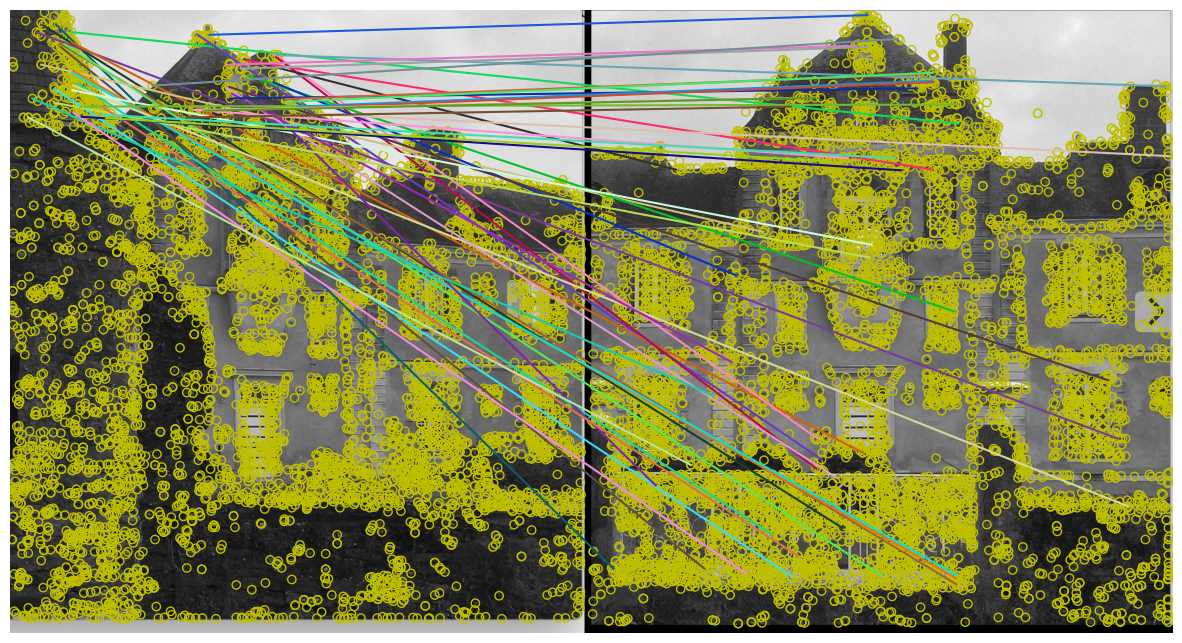

In [69]:
from skimage.feature import plot_matches
fig, ax = plt.subplots(1, 1, figsize=(15, 12))

# Best match subset for image0 -> image1
plot_matches(ax, image0, image1, keypoints0, keypoints1, matches01[range(50)],keypoints_color='y')
ax.axis('off');

**Question 4:** 
- Evaluate visually the quality of the matches. 
- Are any of them obviously wrong ? Do you have any idea why? 
- Are there any unmatched points in the first and/or second image? 
- Is it because these points are out of the field of view in the other image? 
- Does there seem to be a majority of well-matched points? 

It may be easier (or harder) to answer these questions with the following image, which shows all the matches.

**Answer 4:** YOUR ANSWER HERE

### Display of all matches

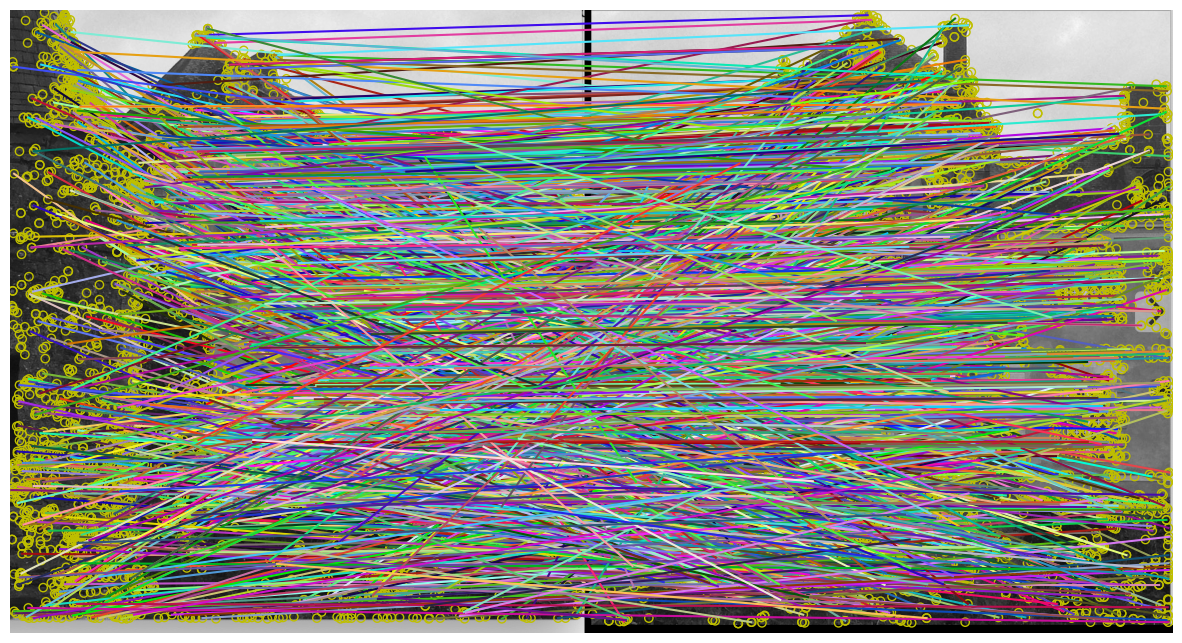

In [70]:
from skimage.feature import plot_matches
fig, ax = plt.subplots(1, 1, figsize=(15, 12))

# Best match subset for pano0 -> pano1
plot_matches(ax, image0, image1, keypoints0, keypoints1, matches01, keypoints_color='y')
ax.axis('off');

## 4. Transform estimation

In an attempt to eliminate mismatches, we use the RANdom SAmple Consensus (RANSAC) method, which eliminates from a statistical estimation process data that do not conform to the majority behavior (robust estimation). In a nutshell, it involves estimating models from various random subsamples of the data, and selecting the best one.

In [71]:
from skimage.transform import ProjectiveTransform,SimilarityTransform
from skimage.measure import ransac

@interact( transform_type = ['Similarity','Projective'] )
def estimate_transform( transform_type ):
    global model_robust01
    global inliers01
    
    # Select keypoints from 
    #   * source (image to be registered): pano0
    #   * target (reference image): pano1, our middle frame registration target
    src = keypoints0[matches01[:, 0]][:, ::-1]
    dst = keypoints1[matches01[:, 1]][:, ::-1]


    if transform_type == 'Similarity':
        model_robust01, inliers01 = ransac((src, dst), SimilarityTransform, min_samples=5, residual_threshold=30, max_trials=1500)
    elif transform_type == 'Projective':
        model_robust01, inliers01 = ransac((src, dst), ProjectiveTransform, min_samples=5, residual_threshold=30, max_trials=1500)
    else:
        raise Exception('Unknown transform type')

    fig, ax = plt.subplots(1, 1, figsize=(15, 12))

    # Best match subset for pano0 -> pano1
    plot_matches(ax, image0, image1, keypoints0, keypoints1, matches01[inliers01])
    plt.show()

    ax.axis('off');


interactive(children=(Dropdown(description='transform_type', options=('Similarity', 'Projective'), value='Simi…

**Question 5:** 
- Experimentally study and comment on the performance of the following transformation models.
    * [Similarity](https://en.wikipedia.org/wiki/Similarity_(geometry)) 
    * [Projective transformation](https://en.wikipedia.org/wiki/Homography). More general than similarity, it is used to deal with the case where a scene is taken from points of view that are very distinct from one another.
- The RANSAC process has left only part of the matches, which it identifies as giving a coherent geometric transformation. We display it below. Does it look right to you?

**Answer 5:** YOUR ANSWER HERE

## 5 Image registration and overlay

We're now going to register the images and overlay them. By registration, we mean that one of the two images will be transformed by the geometric transformation estimated between the two, so that the same points in the scene will (if all goes well) be at the same image coordinates. The two images can then be overlaid to see whether the geometric transformation has been correctly estimated.

In [72]:
# Ici juste une partie de code pour préparer une grande image vide aux bonnes dimensions pour recevoir la superposition des deux images originales

from skimage.transform import SimilarityTransform

# Shape of middle image, our registration target
r, c = image1.shape[:2]

# Note that transformations take coordinates in (x, y) format,
# not (row, column), in order to be consistent with most literature
corners = np.array([[0, 0],
                    [0, r],
                    [c, 0],
                    [c, r]])

# Warp the image corners to their new positions
warped_corners01 = model_robust01(corners)

# Find the extents of both the reference image and the warped
# target image
all_corners = np.vstack((warped_corners01, corners))

# The overally output shape will be max - min
corner_min = np.min(all_corners, axis=0)
corner_max = np.max(all_corners, axis=0)
output_shape = (corner_max - corner_min)

# Ensure integer shape with np.ceil and dtype conversion
output_shape = np.ceil(output_shape[::-1]).astype(int)

### Image transform

Using `skimage.transform.warp`, let's apply the transform obtained in the previous step. The case of the middle image is a little special, as it's our "reference" image, so we only need to translate it to place it at the center of the reconstructed image.

Let's look at the two images placed in a common reference system:

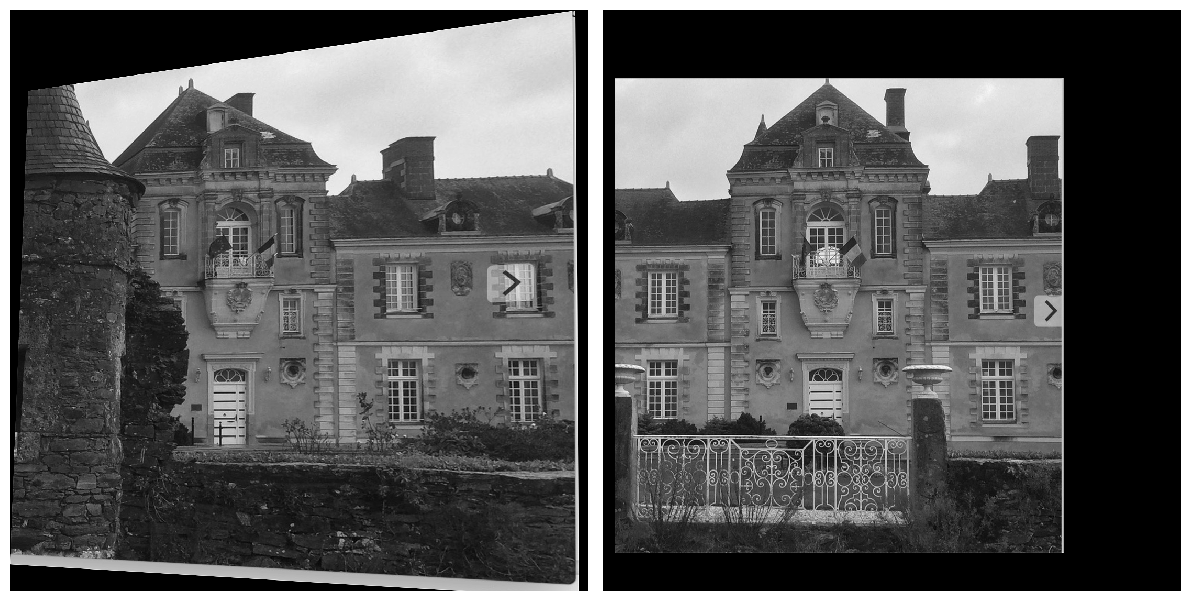

In [73]:
from skimage.transform import warp

# This in-plane offset is the only necessary transformation for the middle image
offset1 = SimilarityTransform(translation= -corner_min)


# Warp image0 to image1 using 3rd order interpolation
transform01 = (model_robust01 + offset1).inverse  
image0_warped = warp(image0, transform01, order=3,
                    output_shape=output_shape, cval=-1)

image0_mask = (image0_warped >= 0)  # Mask == 1 inside image
image0_warped[~image0_mask] = 0      # Return background values to 0


# Translate pano1 into place
image1_warped = warp(image1, offset1.inverse, order=3,
                    output_shape=output_shape, cval=-1)

image1_mask = (image1_warped >= 0)  # Mask == 1 inside image
image1_warped[~image1_mask] = 0      # Return background values to 0

compare(image0_warped, image1_warped, figsize=(12, 8));

Let's overlay these two images:

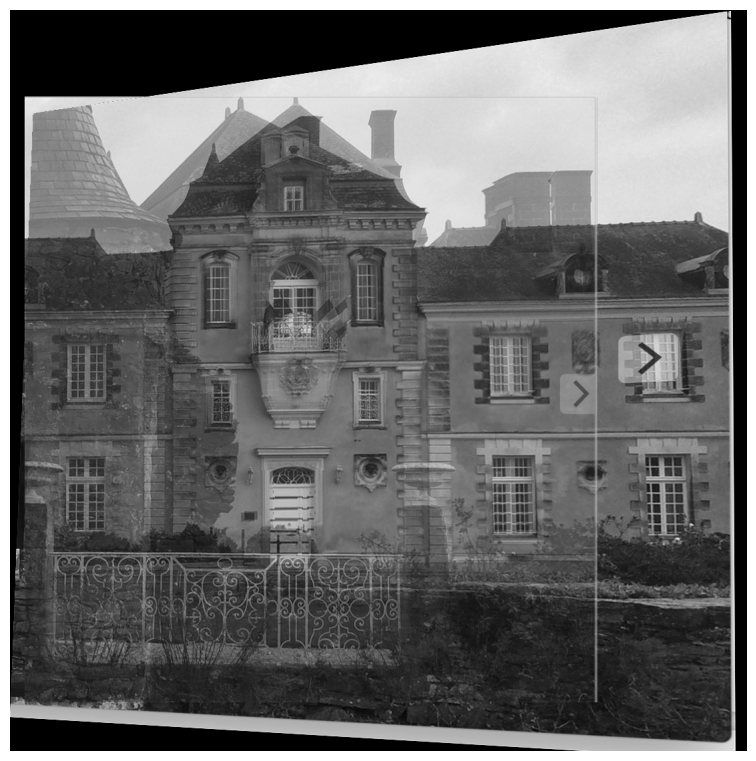

In [74]:
# Add the two images together. This could create dtype overflows!
# We know they are are floating point images after warping, so it's OK.
merged = (image0_warped + image1_warped)

# Track the overlap by adding the masks together
overlap = (image0_mask * 1.0 +  # Multiply by 1.0 for bool -> float conversion
           image1_mask)

# Normalize through division by `overlap` - but ensure the minimum is 1
normalized = merged / np.maximum(overlap, 1)

fig, ax = plt.subplots(figsize=(12, 8))

ax.imshow(normalized, cmap='gray')

plt.tight_layout()
ax.axis('off');

**Question 6:** Comment on the quality of the reconstruction obtained <u>for the different sets of example images provided</u>. Try to explain the cases that don't work well.

**Answer 6:** YOUR ANSWER HERE